In [2]:
!pip install pyarrow
!pip install fastparquet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet('data/catB_train.parquet')

In [3]:
df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


In [4]:
num_data_points = len(df)
num_data_points

17992

In [5]:
df['f_purchase_lh'].value_counts()

f_purchase_lh
1.0    710
Name: count, dtype: int64

In [6]:
df_raw = df.copy()

In [7]:
df.isna().sum()

clntnum                         0
race_desc                    3996
ctrycode_desc                  20
clttype                         0
stat_flag                       0
                            ...  
flg_gi_claim_29d435_ever    17992
flg_gi_claim_058815_ever    17992
flg_gi_claim_42e115_ever    17992
flg_gi_claim_856320_ever    17992
f_purchase_lh               17282
Length: 304, dtype: int64

In [8]:
cols = df.columns
for col in cols:
    if df[col].isna().sum() == num_data_points:
        df.drop(columns=col, inplace=True)

In [9]:
len(df_raw.columns), len(df.columns)

(304, 296)

In [10]:
df.dtypes

clntnum                       object
race_desc                     object
ctrycode_desc                 object
clttype                       object
stat_flag                     object
                              ...   
flg_hlthclaim_14cb37_ever    float64
recency_hlthclaim_14cb37     float64
giclaim_amt                   object
recency_giclaim              float64
f_purchase_lh                float64
Length: 296, dtype: object

In [11]:
df.isna().sum()

clntnum                          0
race_desc                     3996
ctrycode_desc                   20
clttype                          0
stat_flag                        0
                             ...  
flg_hlthclaim_14cb37_ever    16617
recency_hlthclaim_14cb37     16617
giclaim_amt                  17544
recency_giclaim              17544
f_purchase_lh                17282
Length: 296, dtype: int64

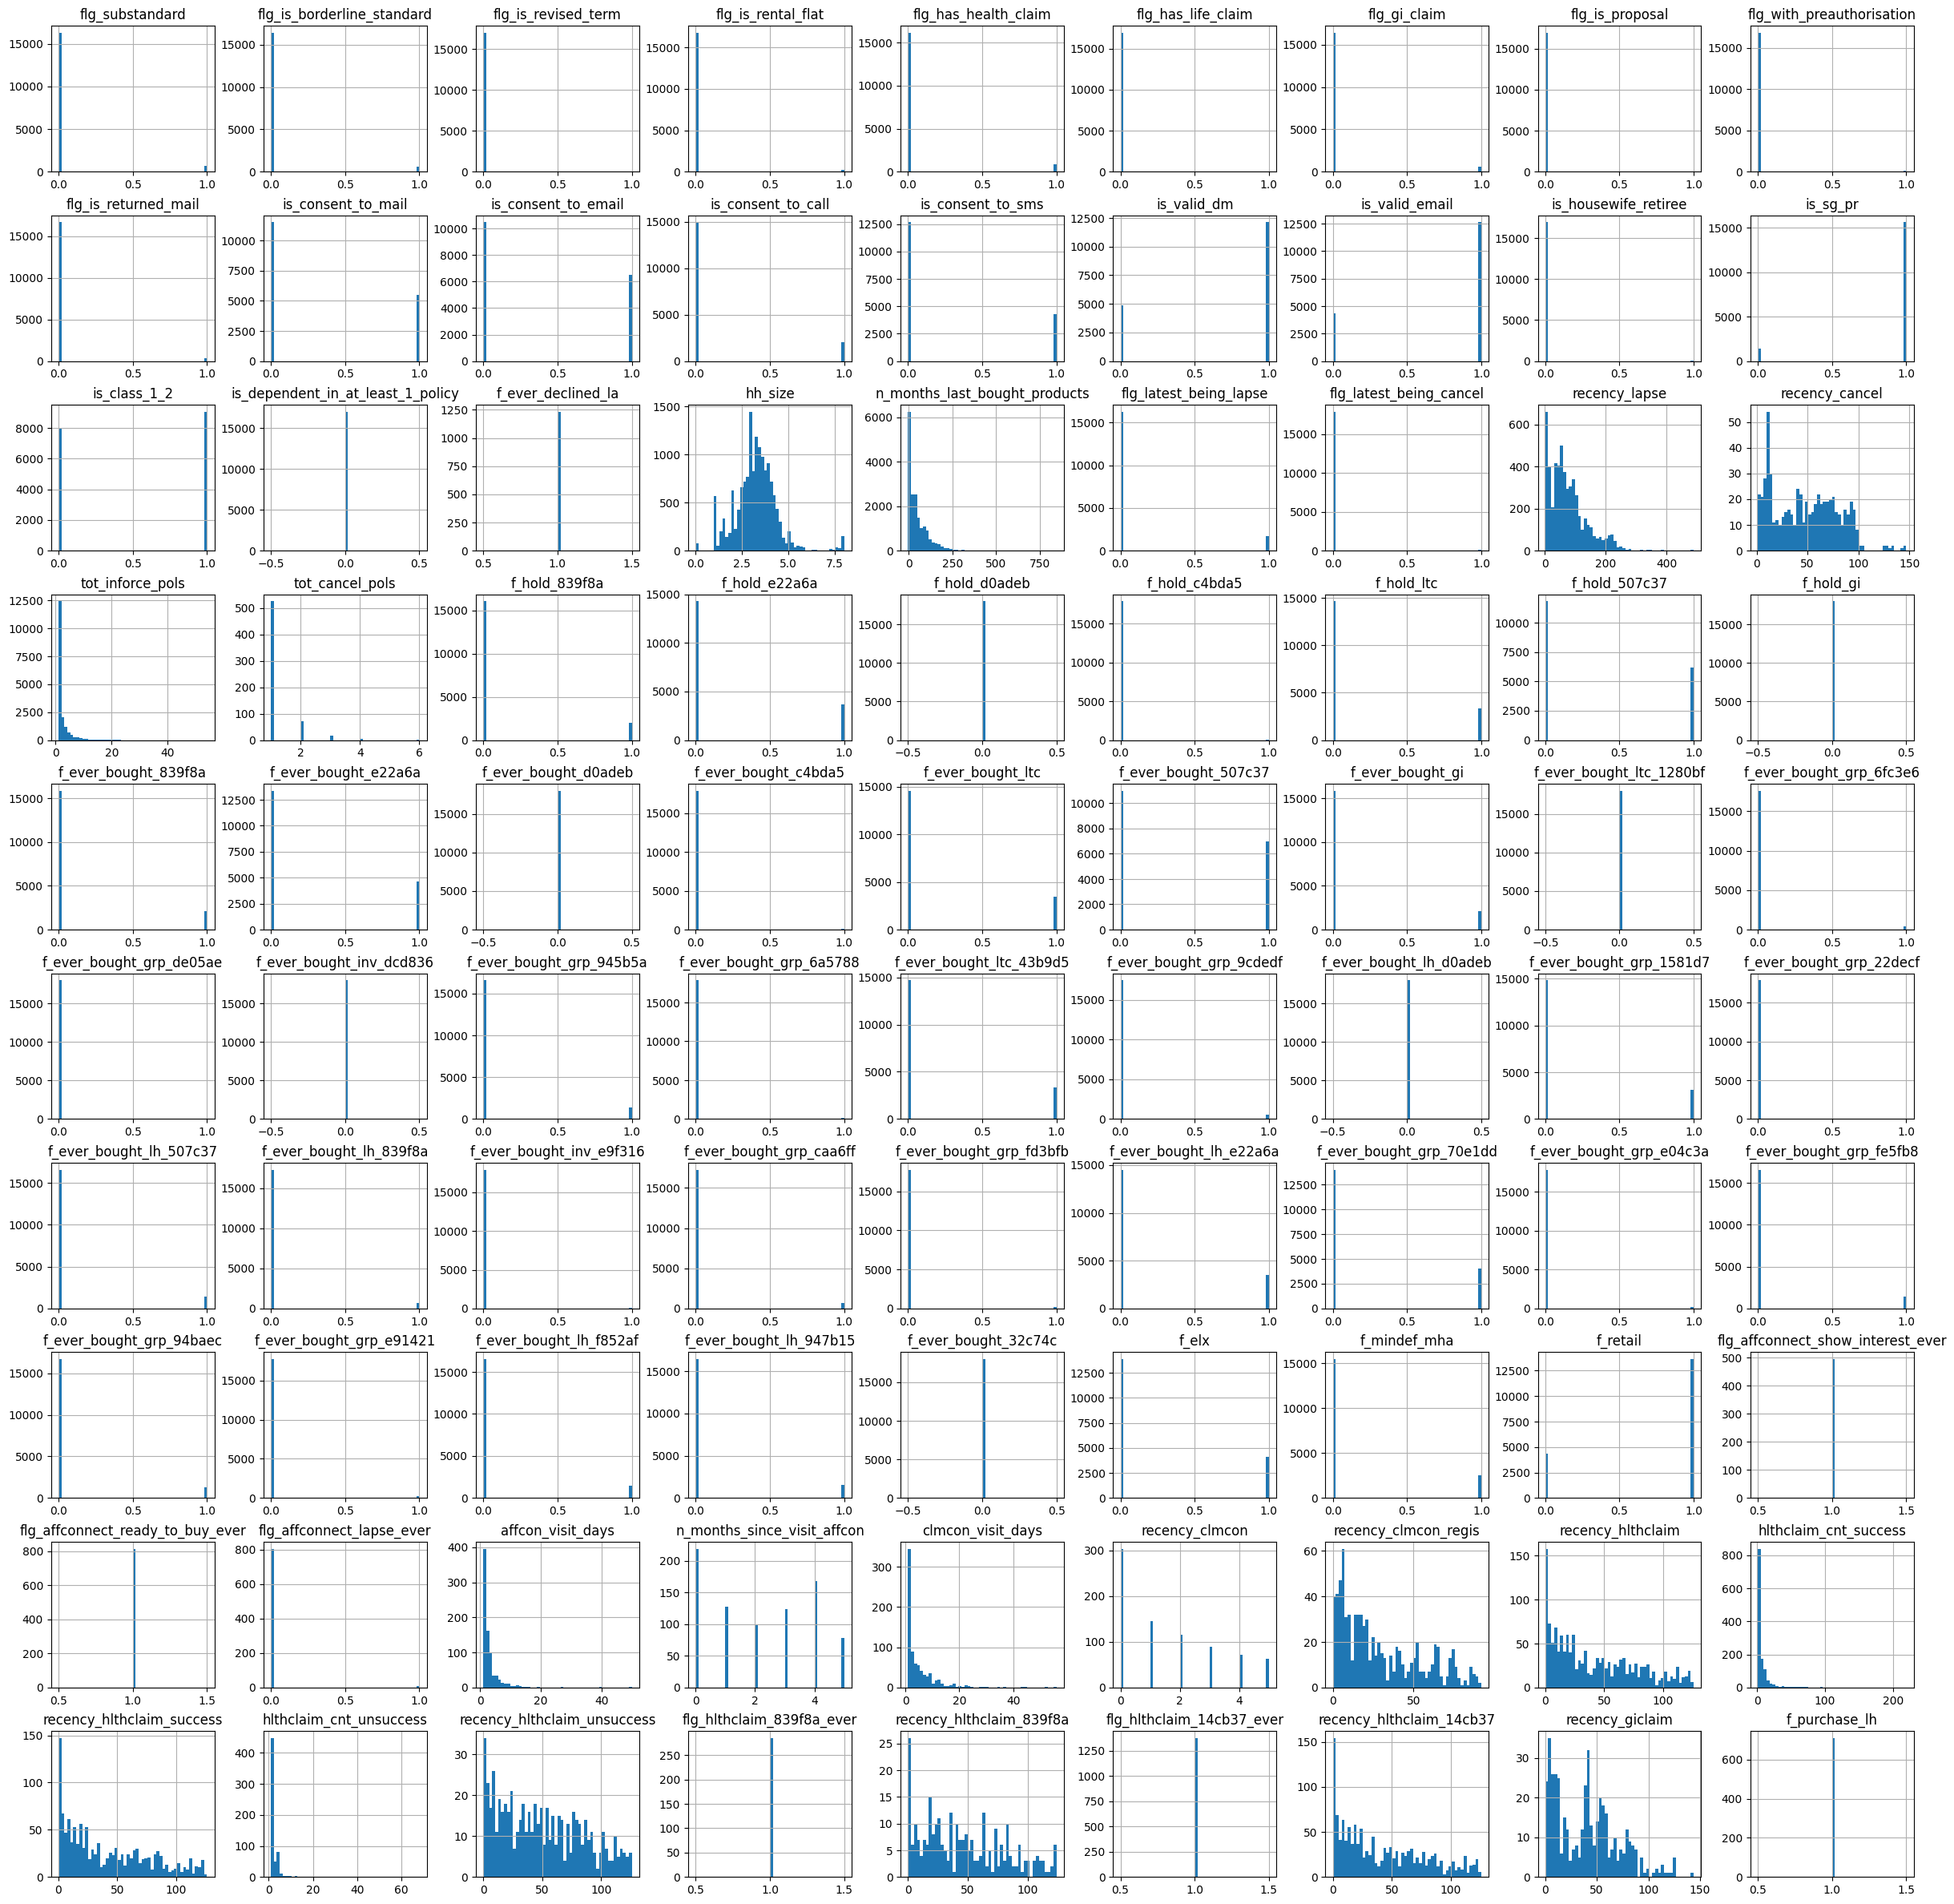

In [12]:
df.hist(figsize=(30, 30), bins=50)
plt.show()

In [ ]:
df.drop(columns='clntnum', inplace=True)

In [15]:
# find numerical and categorical columns
num_cols, cat_cols = [], []
for col in df.columns:
    if df[col].dtype == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [16]:
# handle missing values

# target col: missing => 0
df['f_purchase_lh'].fillna(0, inplace=True)

# categorical cols: missing => 'missing'
for col in cat_cols:
    df[col].fillna('missing', inplace=True)

# numerical cols: missing => median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_23924/1579502208.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['f_purchase_lh'].fillna(0, inplace=True)
/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_23924/1579502208.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [15]:
# handle date cols, which are of type object with format 'YYYY-MM-DD', some of the rows are "None"
# convert to datetime, create new cols for year, month, day and convert to type object
# for rows with "None", fill year, month, day with "None"
date_cols = ['min_occ_date', 'cltdob_fix']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
    df[col+'_year'] = df[col].dt.year.astype('object')
    df[col+'_month'] = df[col].dt.month.astype('object')
    df[col+'_day'] = df[col].dt.day.astype('object')
    df[col+'_year'].fillna('missing', inplace=True)
    df[col+'_month'].fillna('missing', inplace=True)
    df[col+'_day'].fillna('missing', inplace=True)
    df.drop(columns=col, inplace=True)

/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_23520/686117989.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col+'_year'].fillna('missing', inplace=True)
/var/folders/l3/2pgq90f125lbwlmh0s3lrt4m0000gp/T/ipykernel_23520/686117989.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_gi,n_mon

# Model

In [22]:
df['f_purchase_lh'] = df['f_purchase_lh'].astype('int')

X, y = df.drop(columns='f_purchase_lh'), df['f_purchase_lh']

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

X[cat_cols] = X[cat_cols].astype('str')

In [23]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
def k_fold_cv(pipeline, X=X_train_full, y=y_train_full, k=5, oversample=False):
    """
    Perform k-fold cross validation and return:
    - average accuracy score
    - average roc auc score
    - average recall score
    """
    accuracies, roc_auc_scores, f1_scores = [], [], []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        if oversample:
            X_train, y_train = custom_oversample(X_train, y_train)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        y_score = pipeline.predict_proba(X_val)[:, 1]
        accuracies.append(accuracy_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, y_score))
        f1_scores.append(f1_score(y_val, y_pred))
    return np.mean(accuracies), np.mean(roc_auc_scores), np.mean(f1_scores)

In [31]:
log_reg_pipeline = Pipeline([
   ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
   ('logistic_regression', LogisticRegression())
])
acc, roc_auc, f1 = k_fold_cv(log_reg_pipeline)
print(f'Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}')

Accuracy: 0.9592, ROC AUC: 0.7630, F1: 0.1158


In [32]:
rf_pipeline = Pipeline([
   ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
   ('random_forest', RandomForestClassifier())
])
acc, roc_auc, f1 = k_fold_cv(rf_pipeline)
print(f'Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}')

Accuracy: 0.9612, ROC AUC: 0.7328, F1: 0.0000
